In [1]:
import DTR
import PPG_single
import numpy as np
import json

import bm25

ModuleNotFoundError: No module named 'absl'

In [2]:
H_INDEX = -2
N_PAPERS = 3
protected_var_idx = H_INDEX  # rerun author_citations after changing

# Define the 'H' threshold, 'L' if protected_var < threshold
protected_var_threshold = 10

In [1]:
def author_citations():
    d = {}
    author_file = '..\corpus-subset-for-queries.authors.csv'
    header = True
    with open(author_file, 'r', encoding='utf-8') as f:  # d[author_id] = n_citations
        for line in f:
            if header:
                header = False
                continue
            line = line[:-1].split(',')
            author_id = int(line[0])
            # n_citations = int(line[-2])  # Change for experiments
            # n_papers = int(line[-3])
            protected_var = int(line[protected_var_idx])
            d[author_id] = protected_var

    return d

def load_data():

    doc_file = '..\corpus-subset-for-queries.jsonl.txt'
    train_file = '..\TREC-Fair-Ranking-eval-sample.json.txt'

    with open(doc_file, 'r', encoding='utf-8') as f:
        doc_data = json.loads('[{}]'.format(','.join(f)))

    with open(train_file, 'r', encoding='utf-8') as f:
        train_data = json.loads('[{}]'.format(','.join(f)))


    doc_id_idx = {x['id']:i for i, x in enumerate(doc_data)}

    labels = ['title', 'paperAbstract', 'fieldsOfStudy']

    d = {}
    q_docs = {}
    for query in train_data:
        q = query['query']
        d[q] = {}#  {'qid':query['qid']}
        q_docs[q] = query['documents']
        for doc in query['documents']:
            try:
                doc_id = doc['doc_id']
                s = []
                data = doc_data[doc_id_idx[doc_id]]
                s.append(data[labels[0]])
                s.append(data[labels[1]])
                if len(data[labels[2]]) > 0:
                    s.append(' '.join(data[labels[2]]))
                d[q][doc_id] = ' '.join(s)
            except KeyError:
                continue

    return doc_data, doc_id_idx, d, q_docs

In [12]:
import matplotlib.pyplot as plt

0
 5: 0.3174158460714433
 10: 0.7641379310344828
 15: 1.2878506010303377
 20: 1.9970006561064768
 25: 2.948505803902198
 30: 4.184014267185473
 35: 5.928494041170097
 40: 9.542367293109132
 45: 13.741816505301982
 50: 19.91236102027469



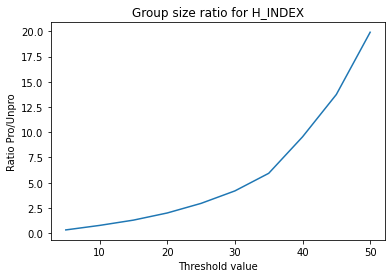

In [19]:
groups = [0, 0]
thresholds = [[5, 10, 15, 20], [10, 20, 30, 50, 80]]

ratios = []
for i, idx in enumerate([-2, 3]):

    print(i)
    protected_var_idx = idx
    author_data = author_citations()
    for threshold in range(5, 55, 5): #thresholds[i]:
        groups = [0, 0]
        
        
        for value in author_data.values():
            groups[value >= threshold] += 1
        
        print(' {}: {}'.format(threshold, groups[0] / groups[1]))
        ratios.append(groups[0] / groups[1])
    print()
    break

plt.plot(list(range(5, 55, 5)), ratios)
plt.xlabel('Threshold value')
plt.ylabel('Ratio Pro/Unpro')
plt.title('Group size ratio for H_INDEX')
plt.savefig('ratio_h_index_5_50')
plt.show()
        

In [4]:
# doc_data: docs info and features
# doc_id_idx: doc_id to doc_data idx
# query_dataset: bm25 input for each query
# query_docs: data per query in train set (qid, freq, documents, relevance labels)
def generate_pre_ranking(author_data, doc_data, doc_id_idx, query_dataset, query_docs, ranking, query):

    # Rank the documents that belong to a query
    # ranking = bm25.rank_bm25(query, query_dataset[query])[:ranking_cutoff]
    # Change this to load in from a file with rankings per query

    if not ranking:  # or sum(y for _, y in ranking) == 0.0:
        return None

    docs_rel = {x['doc_id']:x['relevance'] for x in query_docs[query]}


    # Construct a dict that contains all the info required for reranking
    post_rank_dataset = {'doc_id':[], 'rel':[], 'y_pred':[], 'groups':[]}
    for doc, score in ranking:
        doc_info = doc_data[doc_id_idx[doc]]
        try:
            author_id = int(doc_info['authors'][0]['ids'][0])

        # What to do with documents with a missing author ID?
        except IndexError as e:
            # missing_author_id.add(doc_info['title']) 
            # print('Missing authors for doc:')
            # print(query, doc_info['title'], sep='\n')
            # print()
            author_id = 0
        
        protected_var = author_data.get(author_id, 0)
        # score = max(score, 0.000001)

        doc_rel = docs_rel[doc]
        group = 'L' if protected_var < protected_var_threshold else 'H'  # Change for experiments

        post_rank_dataset['doc_id'].append(doc)
        post_rank_dataset['rel'].append(doc_rel)
        post_rank_dataset['y_pred'].append(score)
        post_rank_dataset['groups'].append(group)

    return post_rank_dataset

In [5]:
def rerank_PPG(pre_ranking, k=None):
    
    y_pred = np.array(pre_ranking['y_pred'])
    groups = np.char.array(pre_ranking['groups'])
    n_docs = min(len(y_pred), k) if k else len(y_pred)

    exposure = np.array([1. / np.log2(2 + i) for i in range(1, n_docs+2)])
    dlr_dtr = np.array([0, n_docs])


    obj_ins = DTR.DTR(y_pred, groups, dlr_dtr, exposure)

    learner = PPG_single.Learner(PPG_mat = None, samples_cnt = 16, objective_ins = obj_ins, sorted_docs = y_pred.argsort()[::-1],
                                intra = np.arange(n_docs), sessions_cnt = 20)

    # print('Starting PPG:\n', learner.PPG)
    # print()

    vals = learner.fit(50, 0.4, 0)  # Epochs, Learnrate hyperparams
    rerank_idx = PPG_single._PPG_sample(learner.PPG)


    # print('=============')
    # print('Learned PPG:\n', learner.PPG)
    # print('=============')
    # print('Sampling PPG:\n')
    # print(rerank_idx)
    # print()

    return rerank_idx

In [6]:
def calculate_DTR(rel_rerank, y_pred_rerank, g_rerank):
    dlr = np.array([0, len(y_pred_rerank)])
    dtr = DTR.calculatedTR(rel_rerank, y_pred_rerank, g_rerank, dlr)
    return dtr
#     exp_L, exp_H, util_L, util_H, *_ = DTR.calculateExposureAndUtility(rel_rerank, y_pred_rerank, g_rerank, 10)
#     return dtr, exp_L, exp_H, util_L, util_H


def dcg_at_k(sorted_labels, k):
    if k > 0:
        k = min(sorted_labels.shape[0], k)
    else:
        k = sorted_labels.shape[0]
    denom = 1./np.log2(np.arange(k)+2.)
    nom = 2**sorted_labels-1.
    dcg = np.sum(nom[:k]*denom)
    return dcg

def ndcg_k(scores, labels, k=10):
    if sum(labels) == 0:
        return 0.0
    sort_ind = np.argsort(scores)[::-1]
    sorted_labels = labels[sort_ind]
    ideal_labels = np.sort(labels)[::-1]
    return dcg_at_k(sorted_labels, k) / dcg_at_k(ideal_labels, k)

In [7]:
with open('bm25_preranking.json', 'r') as f:
    query_rankings = json.loads(f.read())

In [45]:
# output = {query: bm25.rank_bm25(query, query_dataset[query]) for query in query_dataset}
# with open('bm25_preranking.json', 'w') as f:
#     json.dump(output, f)

In [8]:
import os
def listnet_rankings():
    dir_path = '../ListNet-10/'
    files = os.listdir(dir_path)
    
    pre_rankings = []
    groups = ['L', 'H']
    for file in files:
        ranking = {'rel':[], 'y_pred':[], 'groups':[]}
        with open(dir_path+file, 'r') as f:
            for line in f.readlines()[1:]:
                line = line.split(',')
                ranking['rel'].append(float(line[0]))
                ranking['y_pred'].append(float(line[1]))
                ranking['groups'].append(groups[line[-1][0]=='T'])
        
        pre_rankings.append(ranking)
    return pre_rankings

def listnet_pre_ranking(qid):
    ranking = []
    try:
        with open(f'../ListNet-10/ListNet_features_{qid}', 'r') as f:
            for line in f.readlines()[1:]:
                line = line.split(',')
                ranking.append((line[0], line[1], line[-1][0]=='T'))
    except FileNotFoundError:
        return None
    
    print(ranking)
    return ranking

listnet_pre_ranking(95)


[('0.0', '0.038998533', False), ('1.0', '0.01396862', True), ('0.0', '0.003952015', True), ('0.0', '0.00030701235', False), ('0.0', '-0.032134425', True), ('0.0', '-0.032677602', True), ('0.0', '-0.033808064', False), ('0.0', '-0.049183857', True), ('0.0', '-0.05646957', False), ('0.0', '-0.07002409', False)]


[('0.0', '0.038998533', False),
 ('1.0', '0.01396862', True),
 ('0.0', '0.003952015', True),
 ('0.0', '0.00030701235', False),
 ('0.0', '-0.032134425', True),
 ('0.0', '-0.032677602', True),
 ('0.0', '-0.033808064', False),
 ('0.0', '-0.049183857', True),
 ('0.0', '-0.05646957', False),
 ('0.0', '-0.07002409', False)]

In [9]:
doc_data, doc_id_idx, query_dataset, query_docs = load_data()
author_data = author_citations()

In [10]:
# Calculate the ndcg of the preranks separately, since they don't change for different groups
# ndcg_preranks = {}
ndcg_5 = 0.0
ndcg_10 = 0.0
n = 0
# for query in query_dataset:  # BM25 rankings ndcg scores
#     ranking = query_rankings[query]
#     if not ranking:
#         continue
#     pre_ranking = generate_pre_ranking(author_data, doc_data, doc_id_idx,
#                                        query_dataset, query_docs, ranking, query)
for pre_ranking in listnet_rankings():  # Listnet rankings ndcg scores
    n += 1
    y_pred_prerank = np.array(pre_ranking['y_pred'])
    rel_prerank = np.array(pre_ranking['rel'])
    
    ndcg_5 += ndcg_k(y_pred_prerank, rel_prerank, k=5)
    ndcg_10 += ndcg_k(y_pred_prerank, rel_prerank, k=10)
#     ndcg_10_prerank = ndcg_k(y_pred_prerank, rel_prerank, k=10)
#     ndcg_5_prerank = ndcg_k(y_pred_prerank, rel_prerank, k=5)
#     ndcg_preranks[query] = (ndcg_5_prerank, ndcg_10_prerank)

# ndcg_5 = sum([x for x,_ in ndcg_preranks.values()]) / len(ndcg_preranks)
# ndcg_10 = sum([y for _,y in ndcg_preranks.values()]) / len(ndcg_preranks)

print("Preranking:\n-NDCG@10:{}, NDCG@5:{}".format(ndcg_10 / n, ndcg_5 / n))


Preranking:
-NDCG@10:0.4352514773502127, NDCG@5:0.3263088969285556


In [10]:
H_INDEX = -2  # {5, 10, 20}
N_PAPERS = 3  # {20, 40, 60, 80}
protected_var_idx = N_PAPERS  # rerun author_citations after changing

# Define the 'H' threshold, 'L' if protected_var < threshold
protected_var_threshold = 60
# author_data = author_citations()

In [11]:
# missing_author_id = set()  # Majority in docs from covid-19 related queries
failed_rankings = []  # Just one german query for some reason
dtr_zeros = []

random_seeds = [42, 84, 17]
np.random.seed(42)  # Use 3 seeds and average
ranking_cutoff = 10

ndcg_scores = {}  # query: (ndcg10rerank, ndcg10prerank, ndcg5rerank, ndcg5prerank)
dtr_scores = {}  # query: (dtr_rerank, dtr_prerank)

ndcg_scores = {'5':0.0, '10':0.0}
dtr_scores = {'re':0.0, 'pre':0.0}

n = 0
for query in query_dataset:
    ranking = query_rankings[query][:ranking_cutoff]
    pre_ranking = generate_pre_ranking(author_data, doc_data, doc_id_idx,
                                       query_dataset, query_docs, ranking, query)
    if not pre_ranking:
        failed_rankings.append(query)
        continue
# for pre_ranking in listnet_rankings():
    
    y_pred_prerank = np.array(pre_ranking['y_pred'])
    rel_prerank = np.array(pre_ranking['rel'])
    g_prerank = np.char.array(pre_ranking['groups'])
    dtr_prerank = calculate_DTR(rel_prerank, y_pred_prerank, g_prerank)


    for seed in random_seeds:
        n += 1
        np.random.seed(seed)
#         rerank_idx = rerank_PPG(pre_ranking)   # PPG reranking
        rerank_idx = np.arange(len(pre_ranking)) # random reranking
        np.random.shuffle(rerank_idx)


        rel_rerank = np.take(pre_ranking['rel'], rerank_idx)
        y_pred_rerank = np.take(pre_ranking['y_pred'], rerank_idx)
        g_rerank = np.take(pre_ranking['groups'], rerank_idx)

#         dtr, exp_L, exp_H, util_L, util_H = calculate_DTR_exposure_utility(
#             rel_rerank, y_pred_rerank, g_rerank)

    #     ndcg_10_prerank = ndcg_k(y_pred_prerank, rel_prerank, k=10)
        ndcg_10_rerank = ndcg_k(y_pred_rerank, rel_prerank, k=10)
    #     ndcg_5_prerank = ndcg_k(y_pred_prerank, rel_prerank, k=5)
        ndcg_5_rerank = ndcg_k(y_pred_rerank, rel_prerank, k=5)
        
        ndcg_scores['10'] += ndcg_10_rerank
        ndcg_scores['5'] += ndcg_5_rerank

#         if query in ndcg_scores:
#             ndcg_scores[query][0] += ndcg_10_rerank
#             ndcg_scores[query][1] += ndcg_5_rerank
#         else:
#             ndcg_scores[query] = [ndcg_10_rerank, ndcg_5_rerank]

        dtr_rerank = calculate_DTR(rel_rerank, y_pred_rerank, g_rerank)
        dtr_scores['re'] += dtr_rerank
        dtr_scores['pre'] += dtr_prerank

#         if query in dtr_scores:
#             dtr_scores[query][0] += dtr_rerank
#             dtr_scores[query][1] += dtr_prerank
#         else:
#             dtr_scores[query] = [dtr_rerank, dtr_prerank]


    
#     if dtr_rerank == 0.0:
#         dtr_zeros.append((query, pre_ranking['groups']))
#         print(query)
#         print(pre_ranking['groups'])
        
    
#     ndcg_scores[query] = (ndcg_10_rerank, ndcg_10_prerank, ndcg_5_rerank, ndcg_5_prerank)
#     dtr_scores[query] = (dtr_rerank, dtr_prerank)



In [12]:
# Calculate average DTR and NDCG
ndcg_10_re = ndcg_scores['10'] / n
ndcg_5_re = ndcg_scores['5'] / n
dtr_re = dtr_scores['re'] / n
dtr_pre = dtr_scores['pre'] / n

print('Rerank:\n-NDCG@10: {}, NDCG@5: {}\n-DTR: {}'.format(ndcg_10_re, ndcg_5_re, dtr_re))
print('Prerank:\n-DTR: {}'.format(dtr_pre))


Rerank:
-NDCG@10: 0.23680475076069496, NDCG@5: 0.23877759390115505
-DTR: 0.2763015812146201
Prerank:
-DTR: 0.26352216361043224


In [14]:
# Calculate average DTR and NDCG
n_values = len(ndcg_scores)
ndcg_10_re = 0.0
ndcg_5_re = 0.0
ndcg_10_pre = 0.0
ndcg_5_pre = 0.0
for re_10, pre_10, re_5, pre_5 in ndcg_scores.values():
    ndcg_10_re += re_10
    ndcg_5_re += re_5
    ndcg_10_pre += pre_10
    ndcg_5_pre += pre_5

ndcg_10_re = ndcg_10_re / n_values
ndcg_5_re = ndcg_5_re / n_values
ndcg_10_pre = ndcg_10_pre / n_values
ndcg_5_pre = ndcg_5_pre / n_values
    
dtr_re = 0.0
dtr_pre = 0.0
for dtr_re, dtr_pre in dtr_scores.values():
    dtr_re += dtr_re
    dtr_pre += dtr_pre

dtr_re = dtr_re / n_values
dtr_pre = dtr_pre / n_values


print('Rerank:\n-NDCG@10: {}, NDCG@5: {}\n-DTR: {}'.format(ndcg_10_re, ndcg_5_re, dtr_re))
print('Prerank:\n-NDCG@10: {}, NDCG@5: {}\n-DTR: {}'.format(ndcg_10_pre, ndcg_5_pre, dtr_pre))


Rerank:
-NDCG@10: 0.3058114388321735, NDCG@5: 0.30807318249572774
-DTR: 0.0
Prerank:
-NDCG@10: 0.5257371349632226, NDCG@5: 0.3487296752077553
-DTR: 0.00505321770682946


In [ ]:
print(len(dtr_zeros))

In [22]:
print(ndcg_scores)
print(dtr_scores)

{'cloud computing': (0.4632423659320675, 0.4632423659320675, 0.2960819109658652, 0.2960819109658652), 'constitutional law': (0.2716774977597197, 0.227804435066758, 0.16958010263680806, 0.0), 'metalinguistic knowledge': (0.9178287402913374, 0.7397466333385988, 0.787702056960637, 0.6096199500078984), 'usefulness of debit card': (0.6096199500078984, 0.7365896932159578, 0.6096199500078984, 0.7365896932159578), 'facilities management': (0.6131471927654584, 0.2640681225725909, 0.6131471927654584, 0.2640681225725909), 'cloud computing in education': (0.6394562303262419, 0.9469024295259745, 0.49818925746641285, 0.9469024295259745), 'consumer buying behaviour in branded and unbranded clothing': (0.6719882468370725, 0.6256646589861505, 0.5307212739772434, 0.4776237035032179), 'python': (0.2532778777010656, 0.2532778777010656, 0.0, 0.0), 'participatory culture': (0.3543334123470583, 0.4522463376970261, 0.3391602052736161, 0.3391602052736161), 'post harvest diseases of onion': (0.5012658353418871,

In [31]:
# Testing if zero-scores within a ranking causes DTR to become zero
# Result: apparently not
# Hell, even full-zero scores have non-zero DTRs
for i, query in enumerate(query_dataset):
    if i > 10:
        break
    ranking = bm25.rank_bm25(query, query_dataset[query])
    if not ranking:
        continue
    ids, scores = tuple(zip(*ranking))
    if 0.0 in scores and not dtr_scores[query][0] == 0.0:
        print(query, scores, dtr_scores[query])

metalinguistic knowledge (0.7612824890391918, 0.7024782014268117, 0.6340887892244131, 0.5570628191667838, 0.5558570554889336, 0.5267814556633585, 0.3465667471469464, 0.0, 0.0, 0.0) (0.46863366692527886, 0.46294442023059335)
facilities management (0.9362213128045076, 0.8975263586584339, 0.8307155168825484, 0.815255526889537, 0.7790902265709376, 0.7684083277269987, 0.7485880001284602, 0.7328711870491196, 0.7313092189389266, 0.7125280328952629, 0.7109011648530787, 0.701894026072787, 0.6973573821188394, 0.6656091244214257, 0.6056659395852023, 0.5828502362913758, 0.4669492635498579, 0.4394864463592895, 0.4075289605611671, 0.3279254913282557, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0) (0.6836244344154524, 0.6808618432961621)
consumer buying behaviour in branded and unbranded clothing (10.492497332724707, 5.778680920181765, 4.534000609453393, 3.751032472772249, 3.56163512948957, 3.5243284122659646, 2.455549795685407, 2.3591010322349097, 2.08288508911683, 0.855402452071728, 0.8275118629

KeyboardInterrupt: 

In [26]:
dtr_worse = 0
for re, pre in dtr_scores.values():
    if pre > re:
        dtr_worse += 1
print(dtr_worse)

8


In [26]:
re_0 = 0
pre_0 = 0
for re, pre in dtr_scores.values():
    re_0 += re == 0
    pre_0 += pre == 0
print(re_0, pre_0)

88 88


In [23]:
print(failed_rankings)
print(len(failed_rankings), len(query_dataset))  # 3/200 of query rankings failed

['drogenzubereitung', 'робустова', '夏忠军']
3 200


In [13]:
# Apparently there's 2 docs named 'The Uncanny Valley', and one of them has the same author twice,
# but once without a first name and an author ID, which happens to be the first in the list, darn
for doc in doc_data:
    if doc['title'] == 'The Uncanny Valley':
        print(doc)
        print()
        print(doc['authors'])
        print(doc['authors'][0]['ids'])
        print()


{'entities': [], 'magId': '', 'journalVolume': '', 'journalPages': '', 'pmid': '', 'fieldsOfStudy': [], 'year': 2007, 'outCitations': ['5582d3a0a0ee3ed471c2c588fe87f5bdeb993d23', '283bfac9b14d44bfe144a62e4cba7565e89e220c', '7d2a6ab4f17a7c08fab4fc6d8977c009e7a4607a'], 's2Url': 'https://semanticscholar.org/paper/658dac82a4f292ecd7c631c6a61408db75f05d07', 's2PdfUrl': '', 'id': '658dac82a4f292ecd7c631c6a61408db75f05d07', 'authors': [{'name': 'Heloir', 'ids': []}, {'name': 'Alexis Héloir', 'ids': ['2812935']}], 'journalName': '', 'paperAbstract': 'Though originally intended to provide an insight into human psychological reaction to robotic design, the concept expressed by this phrase is equally applicable to interactions with nearly any nonhuman entity. Stated simply, the idea is that if one were to plot emotional response against similarity to human appearance and movement, the curve is not a sure, steady upward trend. Instead, there is a peak shortly before one reaches a completely human 